In [35]:
import random
#import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import csv
from pgmpy.readwrite import BIFReader
import time
from itertools import combinations
import statistics
import bnlearn as bn
from pgmpy.metrics import structure_score
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.estimators import ScoreCache
import gc
from utils import *
from ga_operators import *
from loaders import *
import matplotlib.pyplot as plt

In [36]:
from pgmpy.base import DAG
start_dag = DAG()

In [37]:
print(type(start_dag))

<class 'pgmpy.base.DAG.DAG'>


In [38]:
# create random data sample with 8 variables, 1000 samples
data = pd.DataFrame(np.random.randint(0, 5, size=(5000, 8)), columns=list('ABCDEFGH'))
# test a bayesian network structure
bn = BayesianNetwork([['A','B'], ['A','C'], ['B','D'], ['C','E'], ['D','F'], ['E','G'], ['F','H']])
# compute score
score = (structure_score(bn, data, scoring_method="bic"))
print(score)

-64931.10555186233


In [39]:
start_dag.add_node('A')
start_dag.add_node('B')
start_dag.add_node('C')
start_dag.add_node('D')
start_dag.add_node('E')
start_dag.add_node('F')
start_dag.add_node('G')
start_dag.add_node('H')

start_dag.add_edge('A', 'B')
start_dag.add_edge('A', 'C')
start_dag.add_edge('B', 'D')
start_dag.add_edge('C', 'E')

# compute bic
score = (structure_score(start_dag, data, scoring_method="bic"))
print(score)

-64747.182432004935


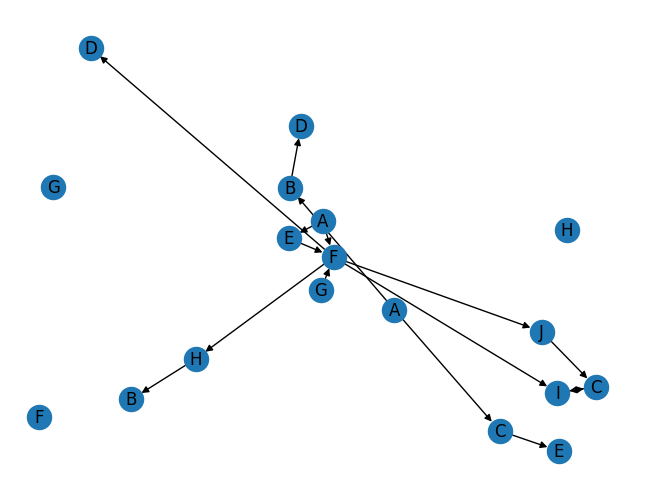

In [40]:
# convert pgmpy DAG to networkx
nx_graph = nx.DiGraph()
nx_graph.add_nodes_from(start_dag.nodes())
nx_graph.add_edges_from(start_dag.edges())
nx.draw(nx_graph, with_labels=True)
plt.show()

In [41]:
def get_connected_nodes(graph):
    # Initialize an empty set to store nodes with at least one edge
    nodes_with_edges = set()

    # Iterate through the edges to collect nodes
    for edge in graph.edges():
        nodes_with_edges.update(edge)

    # Convert the set to a list (if needed)
    nodes_with_edges_list = list(nodes_with_edges) 

    return nodes_with_edges_list

In [42]:
bn2 = BayesianNetwork([['A','B'], ['A','C'], ['B','D'], ['C','E'], ['D','F'], ['E','G']])

In [43]:
nodes1 = get_connected_nodes(bn)
nodes2 = get_connected_nodes(bn2)
print(nodes1)
print(nodes2)

['C', 'D', 'F', 'G', 'B', 'H', 'A', 'E']
['C', 'D', 'F', 'G', 'B', 'A', 'E']


In [44]:
data.head()

,A,B,C,D,E,F,G,H
0,0,2,0,3,2,1,4,4
1,2,1,2,2,4,2,1,1
2,2,4,4,3,0,0,2,1
3,2,0,3,0,1,0,4,2
4,1,4,1,2,0,2,0,4


In [45]:
data2 = data[nodes2]
data2.head()

,C,D,F,G,B,A,E
0,0,3,1,4,2,0,2
1,2,2,2,1,1,2,4
2,4,3,0,2,4,2,0
3,3,0,0,4,0,2,1
4,1,2,2,0,4,1,0


In [46]:
asia = load_asia_data(sample_size=1000)
nodes = asia.columns
nodes = list(nodes)

In [47]:
child = load_child_data(sample_size=100)
nodes_child = child.columns
nodes_child = list(nodes_child)

In [99]:
individual = Individual([], nodes)
sparsity = 0.1
individual.init_random(num_nodes = len(nodes), sparsity = sparsity)

In [103]:
for i in range(100):
    genes_before_mutation = individual.genes
    print(genes_before_mutation)
    mutated = mutation(individual)
    genes_after_mutation = individual.genes
    print(genes_after_mutation)
    print(genes_before_mutation == genes_after_mutation)
    individual = mutated

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]
False
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]
False
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]
[0, 0, 0, 0, 1, 0, 0, 0

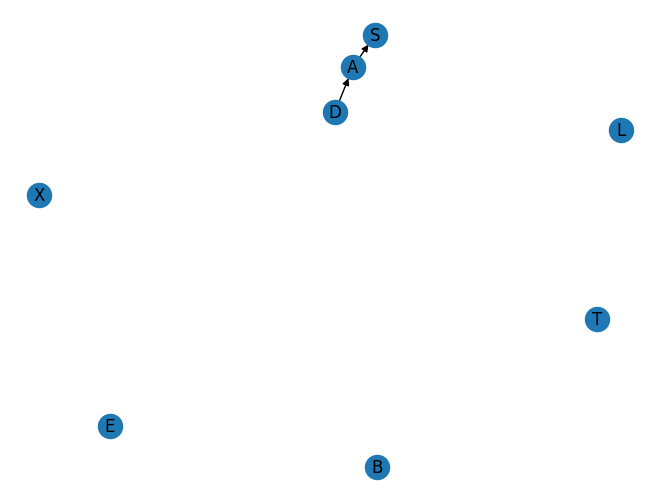

In [84]:
# Draw the graph
nx_graph = individual.individual_to_digraph()
nx.draw(nx_graph, with_labels=True)
plt.show()

In [85]:
before_mutation = copy.deepcopy(individual)

In [86]:
mutated = mutation(individual)

In [87]:
mutated.genes == individual.genes

True

In [88]:
mutated.genes == before_mutation.genes

False

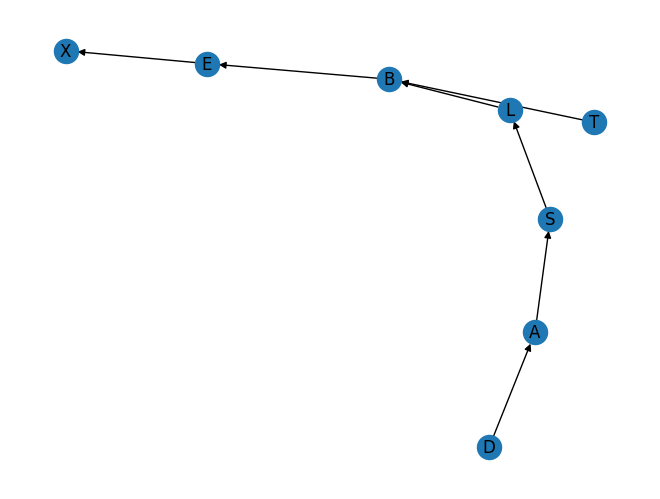

In [89]:
nx_graph = mutated.individual_to_digraph()
nx.draw(nx_graph, with_labels=True)
plt.show()

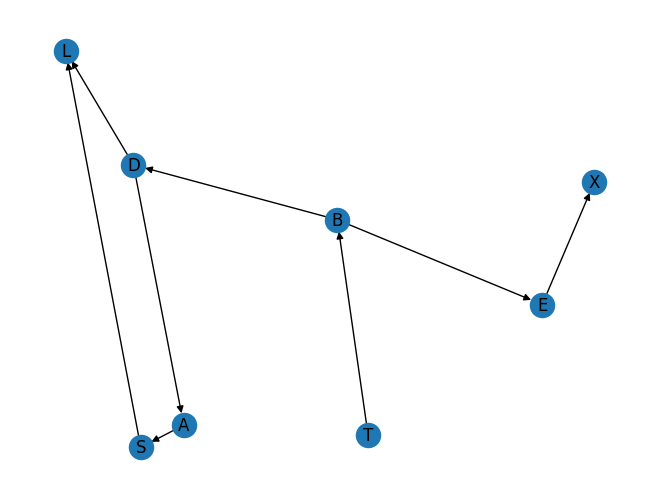

In [94]:
mutated2 = mutation(mutated)
# Draw the graph
nx_graph = mutated2.individual_to_digraph()
nx.draw(nx_graph, with_labels=True)
plt.show()

In [48]:
asia.head()

,S,L,A,T,E,X,B,D
0,1,1,0,0,1,1,1,1
1,0,0,0,0,0,1,1,1
2,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,1,1
4,1,0,0,0,0,0,1,0


In [49]:
gt_adj, node2idx, idx2node = load_gt_adj_asia()

In [50]:
node2idx

{'S': 0, 'L': 1, 'A': 2, 'T': 3, 'E': 4, 'X': 5, 'B': 6, 'D': 7}

In [51]:
gt_adj

array([[0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [52]:
scores = [10,3,5,1,100,8,20,15]
rank = np.argsort(scores)
best_n = rank[:4]
best_n

array([3, 1, 2, 5])

In [53]:
pop = create_population(10, nodes, asia, feasible_only=True)
#pop = create_population(100, nodes_child, child, feasible_only=True)

7


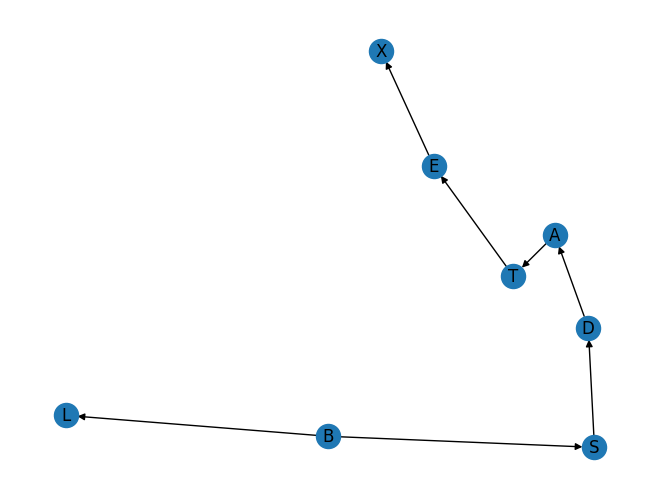

9


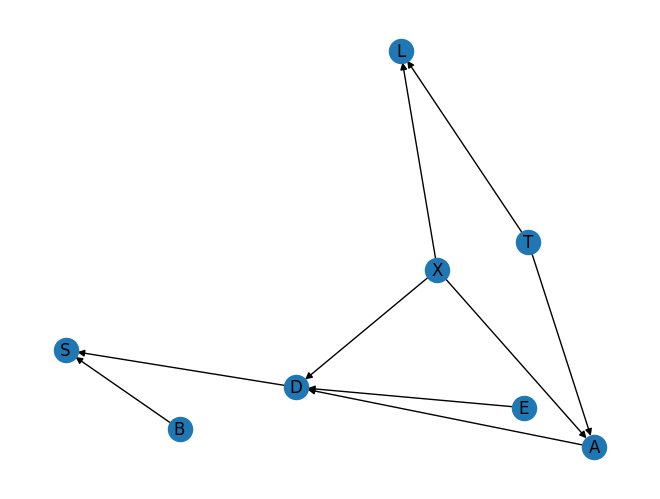

7


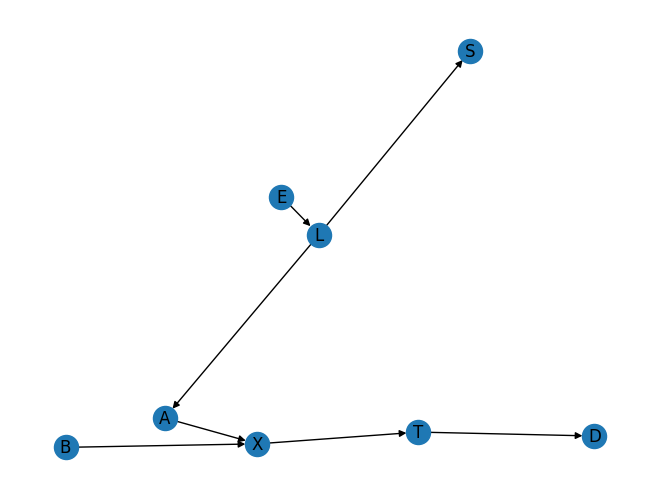

7


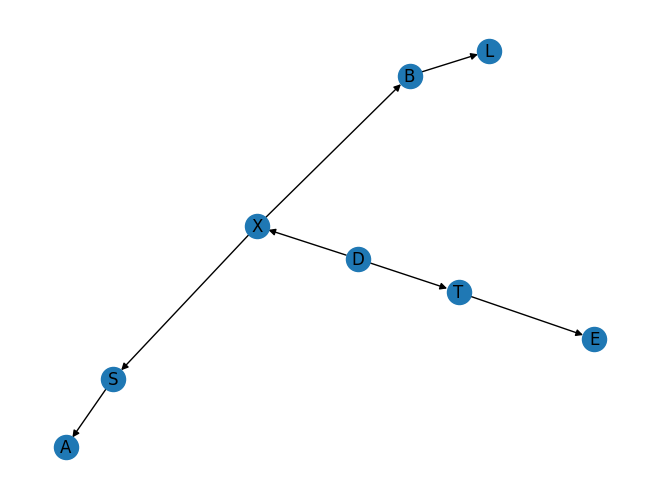

7


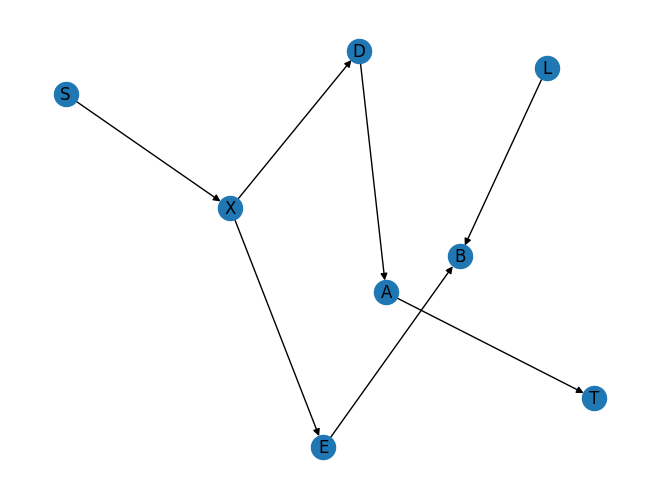

7


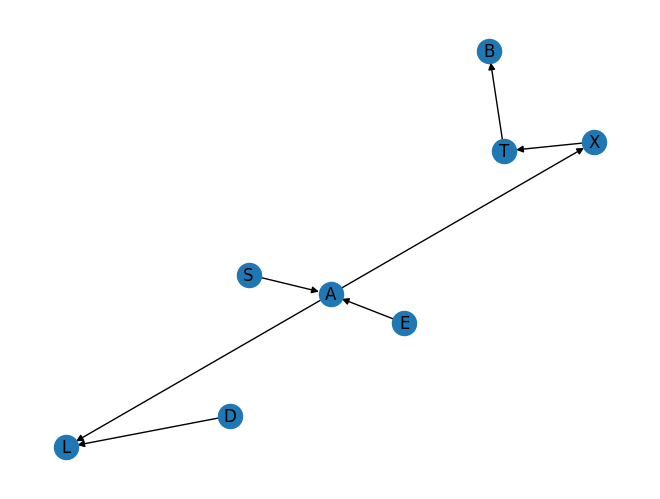

7


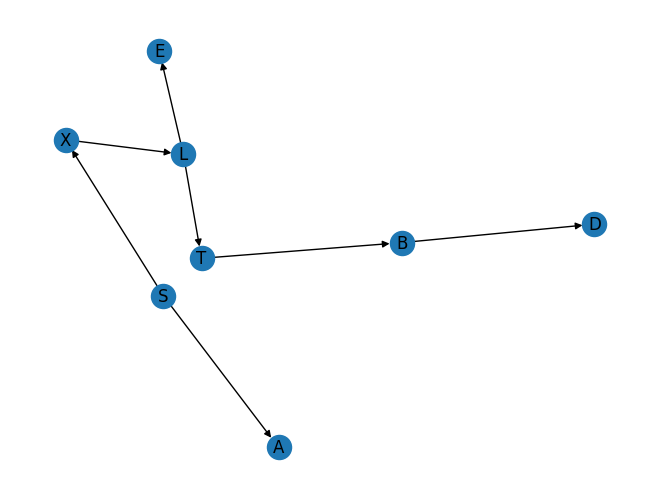

7


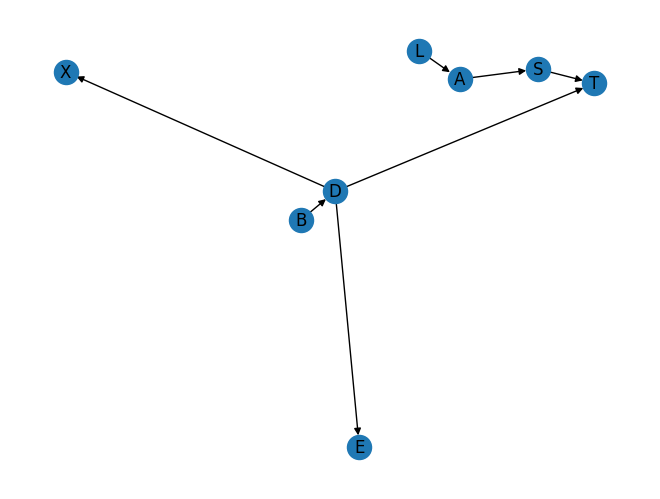

7


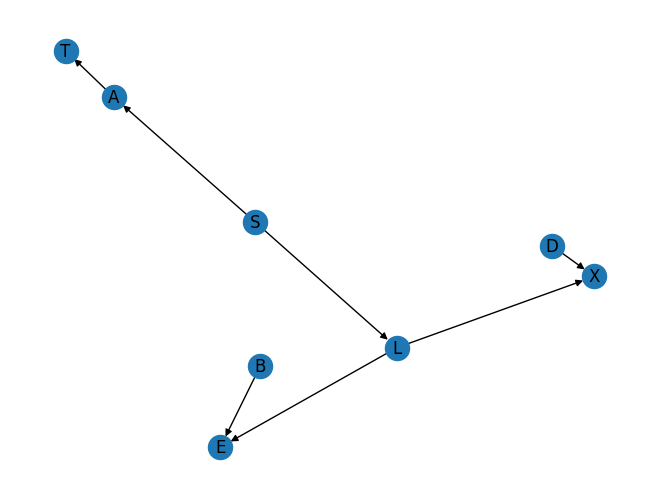

7


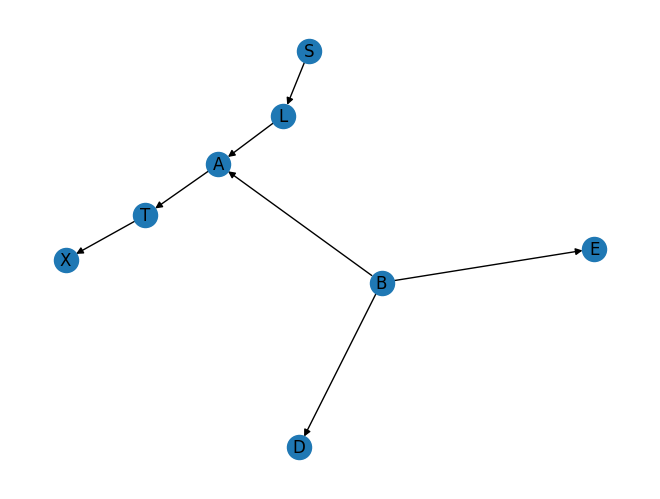

In [54]:
# create a figure for each individual
for ind in pop:
    #print(ind.compute_bic(asia))
    digraph = ind.individual_to_digraph()
    print(digraph.number_of_edges())
    # create a new figure
    plt.figure()
    # plot the DAG
    nx.draw(digraph, with_labels=True, arrows=True)
    # show the figure
    plt.show()


In [55]:
M = nx.adjacency_matrix(G).todense().flatten().tolist()
print(M)
# sum True values
sum(M)

[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


12

In [63]:
individual = Individual([], nodes)
sparsity = 0.1
individual.init_random(num_nodes = len(nodes), sparsity = sparsity)

In [57]:
individual.compute_bic(asia)

ValueError: Missing columns in data. Can't find values for the following variables: set()

In [ ]:
scoring_method = ScoreCache(BicScore(asia), asia).local_score
score = 0
DAG = individual.individual_to_digraph()

for node in DAG.nodes():
    parents = list(DAG.predecessors(node))
    score += scoring_method(node, parents)

print(score)


-2669.094625722928


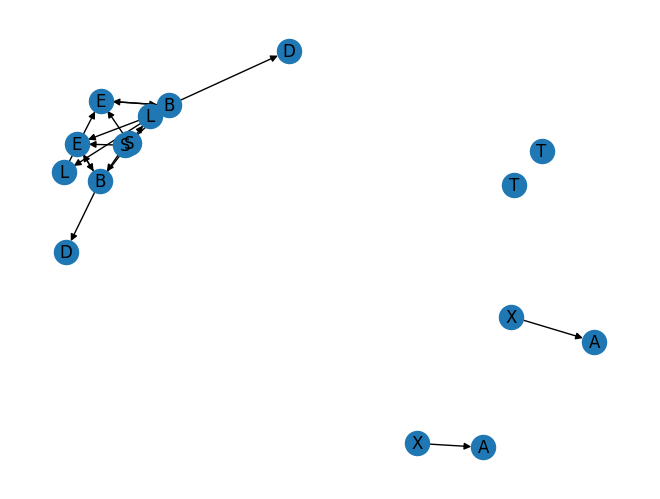

In [65]:
# Draw the individual
#individual.repair_connectivity()
digraph1 = individual.individual_to_digraph()
nx.draw(digraph1, with_labels=True, arrows=True)
plt.show()

In [ ]:
list(digraph1.predecessors('X'))

['A']

In [ ]:
individual.compute_bic(asia)

2676.0603989173133

In [ ]:
G = individual.individual_to_digraph() 

In [ ]:
BIC(G, asia)

2676.0603989173133

In [ ]:
G.remove_edge('A', 'T')
G.add_edge('T', 'A')
BIC(G, asia)

NetworkXError: The edge A-T not in graph.

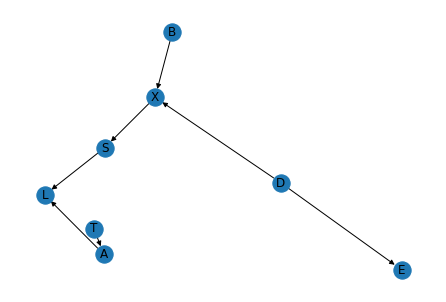

In [ ]:

nx.draw(G, with_labels=True, arrows=True)

In [ ]:
#mutated_ind = individual.uniform_mutation(0.1, True)
mutated_ind = mutation(individual, feasible_only=True)

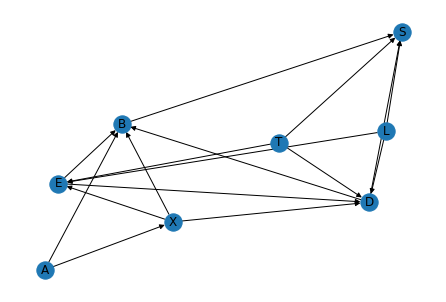

In [ ]:
# Draw the mutated individual
mutated_digraph = individual.individual_to_digraph()
nx.draw(mutated_digraph, with_labels=True, arrows=True)

# Leitura de CHILD

In [ ]:
break here

SyntaxError: invalid syntax (<ipython-input-20-3ef470a3d0aa>, line 1)

In [ ]:
model = bn.import_DAG('../data/child.bif',  CPD=False)

[bnlearn] >Import <../data/child.bif>
[bnlearn] >Loading bif file <../data/child.bif>


In [ ]:
model['adjmat']

target,DuctFlow,HypDistrib,CardiacMixing,HypoxiaInO2,LungParench,CO2,ChestXray,LungFlow,Grunting,Sick,LVH,LVHreport,LowerBodyO2,RUQO2,CO2Report,XrayReport,BirthAsphyxia,Disease,GruntingReport,Age
source,,,,,,,,,,,,,,,,,,,,
DuctFlow,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
HypDistrib,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
CardiacMixing,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
HypoxiaInO2,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False
LungParench,False,False,False,True,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False
CO2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
ChestXray,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
LungFlow,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
Grunting,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [ ]:
# save model adjmat as dataframe
df = pd.DataFrame(model['adjmat'])
df.to_csv('child_adjmat.csv', index=False)

In [ ]:
mat = pd.read_csv('child_adjmat.csv')
mat.head()

,DuctFlow,HypDistrib,CardiacMixing,HypoxiaInO2,LungParench,CO2,ChestXray,LungFlow,Grunting,Sick,LVH,LVHreport,LowerBodyO2,RUQO2,CO2Report,XrayReport,BirthAsphyxia,Disease,GruntingReport,Age
0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
2,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False
4,False,False,False,True,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False


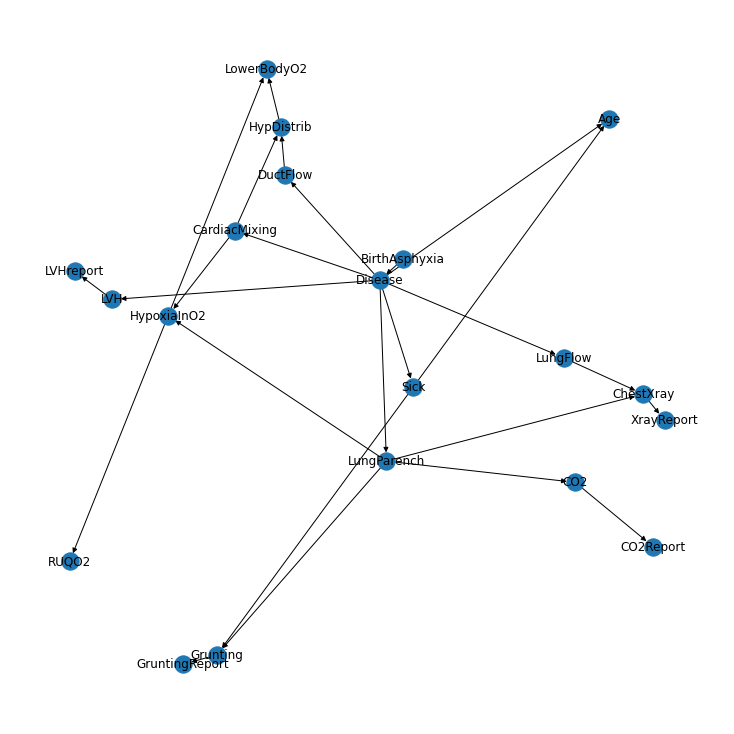

In [ ]:
G = nx.DiGraph(model['adjmat'])
#draw
plt.figure(figsize=(10,10))
nx.draw(G, with_labels=True, arrows=True)
#save graph as directed
nx.write_gml(G, 'child.gml')

In [ ]:
# read graph
G = nx.read_gml('child.gml')

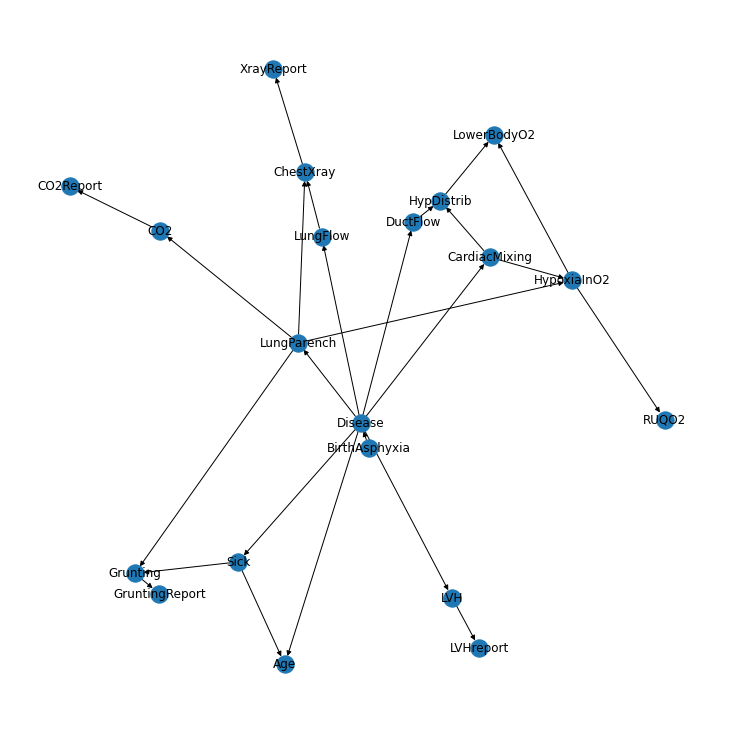

In [ ]:
# draw graph
plt.figure(figsize=(10,10))
nx.draw(G, with_labels=True, arrows=True)

# Leitura INSURANCE

In [ ]:
model = bn.import_DAG('../data/child.bif',  CPD=True)

[bnlearn] >Import <../data/child.bif>
[bnlearn] >Loading bif file <../data/child.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [Age] does not add up to 1 but is: [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[bnlearn] >CPD [ChestXray] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [HypoxiaInO2] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [LowerBodyO2] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [RUQO2] does not add up to 1 but is: [1. 1. 1.]
[bnlearn] >CPD [XrayReport] does not add up to 1 but is: [1. 1. 1. 1. 1.]


In [ ]:
df = bn.sampling(model, n=100000, methodtype='bayes')

In [ ]:
child = load_child_data(sample_size=40000)

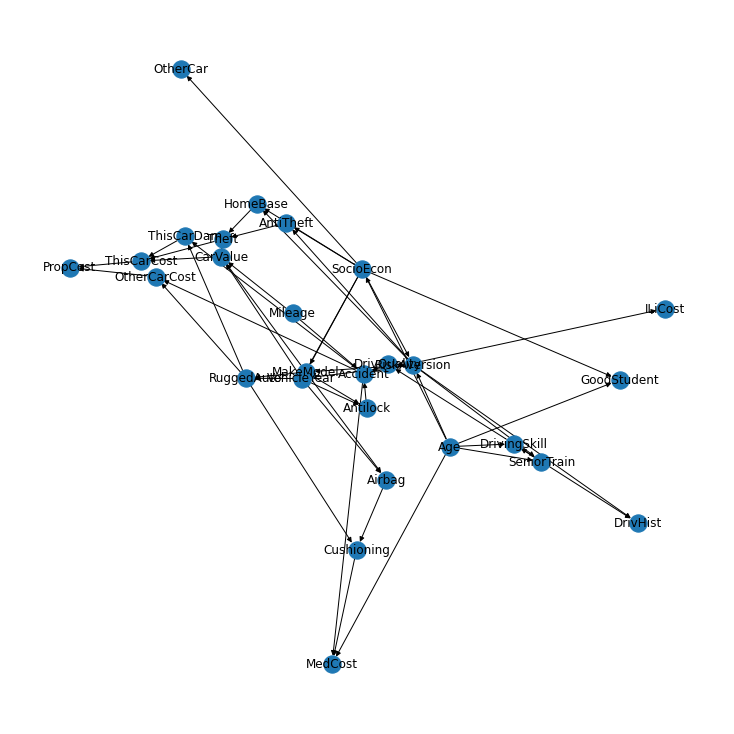

In [ ]:
G = nx.DiGraph(model['adjmat'])
#draw
plt.figure(figsize=(10,10))
nx.draw(G, with_labels=True, arrows=True)
#save graph as directed
nx.write_gml(G, 'insurance.gml')